In [15]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# 이미지 불러오기  (-1 : 이미지 그대로 불러오기, 0 : 흑백으로 불러오기, 1 : 알파 채널 무시한 컬러 이미지 불러오기)
src = cv2.imread('Example Student ID Card2.jpg', -1)
src = cv2.resize(src, (0, 0), fx=0.5, fy=0.5)
dst = src.copy()

# h, w, c
print(src.shape)

if src is None:
    print('Image load failed!')
    sys.exit()
    
# 이미지 분할
rgb_planes = cv2.split(src)

result_planes = []
result_norm_planes = []
for plane in rgb_planes:
    # 팽창 연산을 통해 배경 이미지 생성
    dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
    
    # 배경 이미지를 이용하여 중간 픽셀값 계산
    bg_img = cv2.medianBlur(dilated_img, 21)
 
    # 중간 픽셀값과 입력 이미지의 차이 계산
    diff_img = 255 - cv2.absdiff(plane, bg_img)
    
    # 차이 이미지를 정규화하여 그림자를 강조
    norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    
    # 결과 이미지 리스트에 추가
    result_planes.append(diff_img)
    result_norm_planes.append(norm_img)

# 결과 이미지에 합침
result = cv2.merge(result_planes)
result_norm = cv2.merge(result_norm_planes)

cv2.imshow('shadows_out.jpg', result)
cv2.imshow('shadows_out_norm.jpg', result_norm)
cv2.waitKey(0)
cv2.destroyAllWindows()

(540, 720, 3)


In [18]:
# 그림자 지워졌는지 확인하기 위해 sub함수로 어둡게 설정
val = 100
array = np.full(result_norm.shape, (val, val, val), dtype=np.uint8)

sub = cv2.subtract(result_norm, array)

cv2.imshow("sub", sub)
cv2.waitKey(0)
cv2.destroyAllWindows()

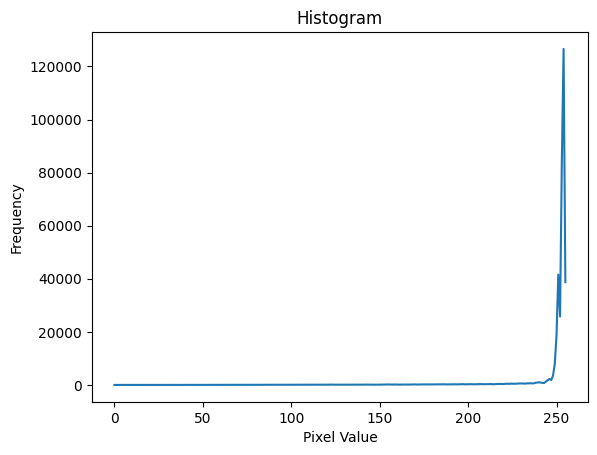

In [21]:
# 흑백으로 변환
src_gray = cv2.cvtColor(result_norm, cv2.COLOR_BGR2GRAY)

# 히스토그램 계산
hist = cv2.calcHist([src_gray], [0], None, [256], [0, 256])

# 히스토그램 그래프 그리기
plt.plot(hist)
plt.title('Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

cv2.imshow('src_gray', src_gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [22]:
# 가우시안 블러
src_blurred = cv2.GaussianBlur(src_gray, ksize=(7, 7), sigmaX=0)

cv2.imshow('src_blurred', src_blurred)
cv2.waitKey(0)
cv2.destroyAllWindows()

213.0


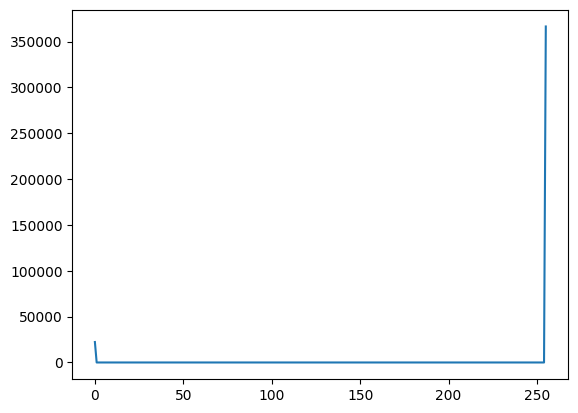

In [26]:
# 이진화 - otsu
ret, src_thresh = cv2.threshold(src_blurred, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
print(ret)

# 히스토그램
hist = cv2.calcHist([src_thresh], [0], None, [256], [0,256]) # 꼭 리스트 형태로 입력

plt.plot(hist)
plt.show()

cv2.imshow('src_thresh', src_thresh)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [27]:
# 수직 투사로 x축 확인
vertical_projection = np.sum(src_thresh, axis=0)

# 수직 투사 결과 확인
print("수직 투사 결과:", vertical_projection)

# 수평 투사로 y축 확인
horizontal_projection = np.sum(src_thresh, axis=1)

# 수평 투사 결과 확인
print("수평 투사 결과:", horizontal_projection)

수직 투사 결과: [137700 137700 137700 137700 137700 137700 137700 137700 137700 137700
 137700 137700 137700 137700 137700 137700 137700 137700 137700 137700
 137700 137700 137700 137700 137700 137700 137700 137700 137700 137700
 137700 137700 137190 136680 135915 135150 133620 132345 132090 132090
 132090 132090 132090 133875 134385 135405 136170 136425 136935 137190
 137700 137700 137700 137700 137700 135660 134895 135660 135405 134130
 134130 133875 133875 134130 134130 134385 134385 134640 134640 134640
 134640 134895 134895 135150 134895 135150 135150 135405 135150 135405
 135405 135660 135660 135405 135660 135660 135660 135660 135660 135660
 135915 135915 135915 135915 135915 135915 135915 135915 135915 136170
 136170 136170 136170 136170 136170 136170 136170 136170 135915 135915
 135915 135915 136170 136170 136170 136170 135915 135915 135915 135660
 135915 135915 135915 135660 135660 135660 135915 135915 135660 135660
 135660 135915 135915 135660 135660 135915 135915 134640 133875 133

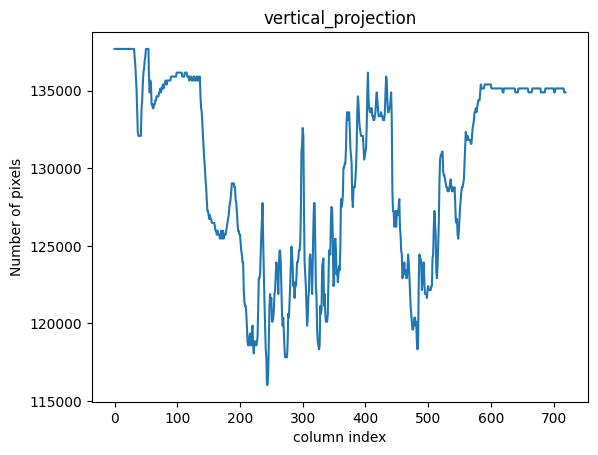

In [28]:
# 수직 투사 그래프로 표현
plt.plot(vertical_projection)
plt.xlabel("column index")
plt.ylabel("Number of pixels")
plt.title("vertical_projection")
plt.show()

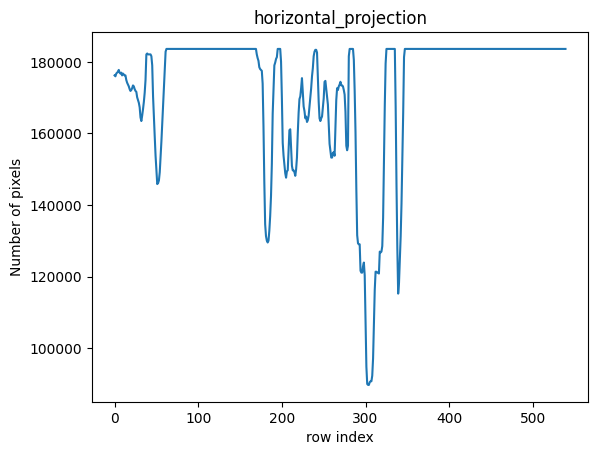

In [29]:
# 수평 투사 그래프로 표현
plt.plot(horizontal_projection)
plt.xlabel("row index")
plt.ylabel("Number of pixels")
plt.title("horizontal_projection")
plt.show()

In [35]:
# 리사이즈할 이미지의 크기
new_size = (500, 500)  # 새로운 크기 (가로, 세로)

# 수직 투사와 수평 투사의 범위 조정 비율
vertical_ratio = 0.2  # 수직 투사 범위 조정 비율
horizontal_ratio = 0.2  # 수평 투사 범위 조정 비율

# 수직 투사의 픽셀 값 범위 설정
vertical_range = (np.min(vertical_projection), np.max(vertical_projection))
vertical_threshold = vertical_range[0] + vertical_ratio * (vertical_range[1] - vertical_range[0])

# 수평 투사의 픽셀 값 범위 설정
horizontal_range = (np.min(horizontal_projection), np.max(horizontal_projection))
horizontal_threshold = horizontal_range[0] + horizontal_ratio * (horizontal_range[1] - horizontal_range[0])

# 픽셀 값에 해당하는 인덱스 추출
vertical_indices = np.where(vertical_projection >= vertical_threshold)[0]
horizontal_indices = np.where(horizontal_projection >= horizontal_threshold)[0]

# 추출된 인덱스에 해당하는 부분 이미지 리사이즈
cropped_image = src_gray[vertical_indices[0]:vertical_indices[-1], horizontal_indices[0]:horizontal_indices[-1]]
resized_image = cv2.resize(cropped_image, new_size)

# 이미지 출력 또는 저장
cv2.imshow("Original Image", src_gray)
cv2.imshow("Resized Image", resized_image)
cv2.waitKey(0)
cv2.destroyAllWindows()